#Ch04. 분류

##05. GBM


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DF로 로드
feature_name_df = pd.read_csv('features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df

In [ ]:
from re import X
def get_human_dataset():
  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv('features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train = pd.read_csv('X_train.txt', sep = '\s+', names = feature_name)
  X_test = pd.read_csv('X_test.txt', sep = '\s+', names = feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv('y_train.txt', sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv('y_test.txt', sep = '\s+', header = None, names = ['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함, 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1231.4초


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(X_train, y_train)

print('최적의 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


KeyboardInterrupt: 

In [38]:
# GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

NameError: name 'grid_cv' is not defined

## 06. XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
print(xgb.__version__)

2.1.1


### 파이썬 래퍼 XGBoost 실습 - 위스콘신 유방암 예측 실습

**<모듈 로딩, 데이터프레임 로드>**

In [47]:
import xgboost as xgb
from xgboost import plot_importance   # 피처의 중요도를 시각화해주는 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


- 타깃 레이블 값
0: 악성
1: 양성

**<레이블 값의 분포 확인>**

In [24]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


**<학습 데이터, 테스트 데이터 분할>**

In [25]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환하는 예제

In [26]:
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

**<XGBoost의 하이퍼 파라미터 설정>**
- XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력
- max_depth: 3
- 학습률 eta: 0.1(XGBClassifier를 사용할 경우 eta가 아니라 learning_rate)
- 목적함수: 이진 로지스틱(예제 데이터가 0 또는 1인 이진 분류이므로)
- 오류 함수의 평가 성능 지표: logloss
- num_rounds(부스팅 반복 횟수): 400

In [27]:
params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stopping':100
          }
num_rounds = 400

**<지정된 하이퍼 파라미터로 XGBoost 모델 학습>**

- 조기 중단은 xgboost의 train( )함수에 early_stopping_rounds 파라미터를 입력하여 설정
- eval_set과 eval_metric이 함께 설정되어야 함
- eval_set: 성능 평가를 수행할 평가용 데이터 세트
- eval_metric: 평가 세트에 적용할 성능 평가 방법(분류일 경우 주로 'error', 'logloss' 적용)
- evlas 파라미터에 학습 데이터 세트와 eval 데이터 세트를 명기하면 평가를 eval 데이터 세트에 수행하면서 조기 중단을 적용
- 조기 중단을 수행하려면 반드시 evals 파라미터에 eval 데이터 세트를 명기해야함

In [28]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 trian()함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, evals = wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

train( )으로 학습을 수행하면 반복 시 train-error와 eval-logloss가 지속적으로 감소

**<테스트 데이터 세트에 예측>**
- 파이썬 래퍼 XGBoost는 train( )함수를 호출해 학습이 완료된 모델 객체를 반환
  => 이 모델 객체는 예측을 위해 predict( ) 메서드를 이용
- 사이킷런의 predict( ) 메서드: 예측 결과 클래스값(0, 1)을 반환
- xgboost의 predict( ) 메서드: 예측 결과를 추정할 수 있는 확률 값을 반환
- 본 예제는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정하는 로직을 추가 **굵은 텍스트**

In [29]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.944 0.005 0.881 0.156 0.994 1.    1.    1.    0.997 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


**<예측 성능 평가>**

In [30]:
# 3장에서 생성한 함수
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred)
  print('오차 행렬')
  print(confusion)

  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))



In [31]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9665


**<피처 중요도 시각화>**
- xgboost의 plot_importance( ) API 사용
- 기본 평가 지표: f1 스코어
- 사이킷런: Estimator 객체의 feature_importances 속성을 이용해 직접 시각화 코드 작성
- xgboost 패키지: plot_importance( )를 이용해 바로 피처 중요도를 시각화
  => plot_importance( ) 호출 시 파라미터로 앞에서 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체 입력
- xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수 없음
  => f0, f1과 같이 피처 순서별로 숫자를 붙여 나열

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

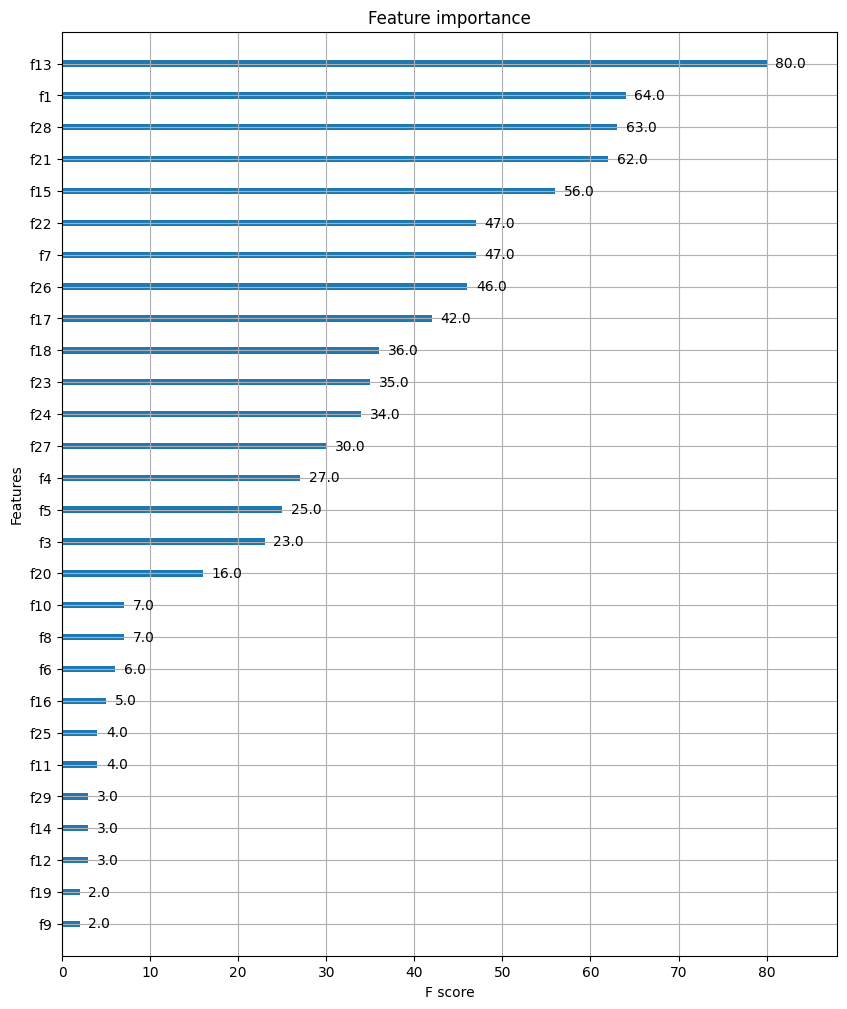

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax = ax)

 ### 사이킷런 래퍼 XGBoost 실습 - 위스콘신 유방암 예측 실습


In [33]:
!pip install --upgrade xgboost

In [34]:
import xgboost as xgb
print(xgb.__version__)

2.1.1


In [35]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stopping':100
          }
num_rounds = 400

wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params=params,dtrain=dtrain,num_boost_round = num_rounds, early_stopping_rounds = 100,evals =wlist)
pred_probs = xgb_model.predict(dtest)
print(pred_probs.shape)
print(np.round(pred_probs[:10],3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])

(455, 30) (114, 30)
[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eva

In [36]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

**<예측 성능 평가>**

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9665


파이썬 래퍼 XGBoost와 동일한 평가 결과


***아무리 수정해봐도 early_stopping_rounds에서 오류가 발생합니다***




**<조기 중단값 = 100>**

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

In [ ]:
# early_stopiing_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'logloss',
                eval_metrics = "logloss", eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

**<시각화>**

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax = ax)

## 07. LightGBM

**<조기 중단 수행>**

In [2]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state = 156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [39]:
get_clf_eval(y_test, preds, pred_proba)

NameError: name 'pred_proba' is not defined

**<시각화>**

NameError: name 'lgbm_wrapper' is not defined

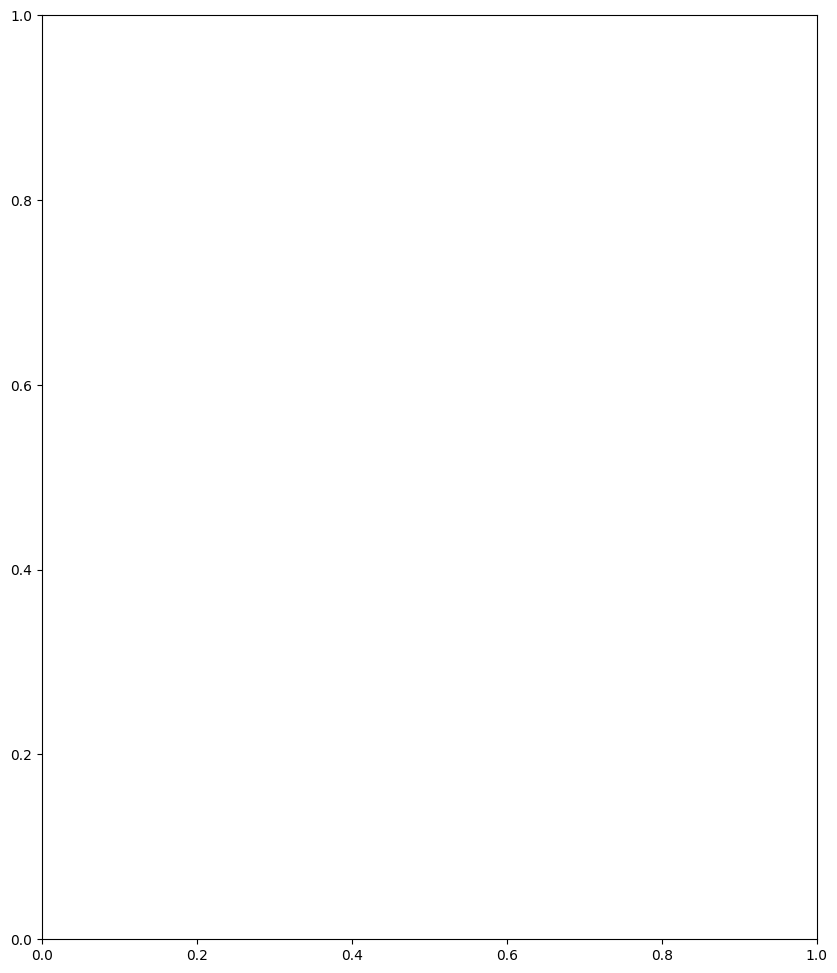

In [40]:
# plot_importance( )를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)

## 10. 스태킹

### 기본 스태킹 모델

**<데이터 로딩, 데이터 세트 나누기>**

In [1]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size = 0.2, random_state = 0)

**<ML 알고리즘 클래스 생성>**
- 개별 모델: KNN, 랜덤 포레스트, 결정 트리, 에이다부스트
- 최종 모델: 로지스틱 회귀


In [2]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

# 스태킹으로 만들어진 데이터세트를 학습, 예측할 최종 모델 생성
lr_final = LogisticRegression(C = 10)

**<개별 모델 학습>**

In [3]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

**<개별 모델의 예측 데이터 세트 반환, 각 모델의 예측 정확도 측정>**

In [4]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


**<최종 메타 모델 생성>**
- 개별 알고리즘으로 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용
- 반환된 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose( )를 이용해 행과 열 위치를 바꾼 ndarray로 변환

In [5]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듬
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


**<최종 메타 모델의 예측 정확도 측정>**

In [9]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


스태킹 기법으로 예측한다고 무조건 개별 모델보다는 좋아진다는 보장 없음

###CV 세트 기반의 스태킹

#### step1

<개별 모델이 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성>
- get_stacking_base_datasets( ) 함수를생성
    : 이 함수에서는 개별 모델의 Classifier 객체, 원본인  학습용 피처 데이터, 원본인 학습용 레이블 데이터, 원본인 테스트 피처 데이터, K폴드를 몇개로 할지를 파라미터로 입력
- 함수 내에서는 폴드의 개수만큼 반복을 수행하면서 폴드된 학습용 데이터로 학습한 뒤예 예측 결괏값을 기반으로 메타 모델을 위한 학습용 데이터와 테스트용 데이터를 새롭게 생성

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

<여러 개의 분류 모델별로 stack_base_model( ) 함수 수행>
- 개별 모델: KNN, 랜덤 포레스트, 결정 트리, 에이다부스트
- 모델별로 stacking_base_datasets( ) 함수를 호출 => 각각 메타 모델이 추후에 사용할 학습용, 테스트용 데이터 세트를 반환

In [20]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  1 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  2 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  3 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  4 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  5 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  6 시작


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


####step2

- 앞의 예제에서 get_stacking_base_datasets( ) 함수를 이용해 반환된 각 모델별 학습 데이터와 테스트 데이터를 합치기
- 넘파이의 concatenate( )를 이용해 이어 붙임
  : 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐줌

In [21]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis = 1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis = 1)

print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


=>
- 이렇게 만들어진 Stack_final_X_train은 메타 모델이 학습할 학습용 피처 데이터 세트
- Stack_final_X_test는 메타 모델이 예측할 테스트용 피처 데이터 세트
- 스태킹 학습 피처 데이터는 원본 학습 피처 데이터와 로우 크기는 같음. 4개의 개별 모델 예측값을 합친 것이므로 칼럼 크기는 4

<최종 메타 모델을 학습 후 예측, 정확도 측정>
- 최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습
- 스태킹된 테스트 데이터 세트로 예측
- 예측 결과를 원본 테스트 레이블 데이터와 비교해 정확도 측정

In [22]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9649


##08. HyperOpt

<입력값 검색 공간 지정>

In [41]:
from hyperopt import hp

# -10 ~ 10까지 1 간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
# hp.quniform 이용
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1)}

<목적함수 생성>

In [62]:
from hyperopt import STATUS_OK

# 목적함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    loss = x ** 2 - 20 * y

    return {'loss': loss, 'status': STATUS_OK}

<베이지안 최적화>

In [63]:
from hyperopt import fmin, tpe, Trials

# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5, trials = trial_val, rstate = np.random.default_rng(seed = 0))

print('best: ', best_01)

100%|██████████| 5/5 [00:00<00:00, 550.65trial/s, best loss: -224.0]
best:  {'x': -4.0, 'y': 12.0}


In [64]:
trial_val = Trials()

# max_evals를 20으로 늘려서 재테스트
best_02 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20, trials = trial_val, rstate = np.random.default_rng(seed = 0))

print('best: ', best_02)

100%|██████████| 20/20 [00:00<00:00, 611.56trial/s, best loss: -296.0]
best:  {'x': 2.0, 'y': 15.0}


<fmin( ) 함수의 Trials 객체>

In [65]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {’loss’: 함수 반환값, ‘status’: 반환 상태값}과 같은 딕셔너리
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [66]:
# Trials 객체의 vals 속성에 {’입력변수명’: 개별수행시마다 입력된 값의 리스트} 형태로 저장
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [67]:
print(trial_val.vals.keys())

dict_keys(['x', 'y'])


In [68]:
import pandas as pd

# results에서 loss 키 값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


###HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [48]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

In [49]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, leaning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                  'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                  'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [51]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임, -1*정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
  # 수행 시간 절약을 위해 n_estimators는 100으로 축소
  xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          leaning_rate = search_space['learning_rate'],
                          colsample_bytree = search_space['colsample_bytree'],
                          eval_metric = 'logloss')
  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)

  # accuracy는 cv = 3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
  return {'loss': -1*np.mean(accuracy), 'status': STATUS_OK}

In [52]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn = objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trial_val,
            rstate = np.random.default_rng(seed = 9))
print('best: ', best)

100%|██████████| 50/50 [00:22<00:00,  2.22trial/s, best loss: -0.9736406413384455]
best:  {'colsample_bytree': 0.548301545497125, 'learning_rate': 0.1840281762576621, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [53]:
print('colsample_bytree: {0}, leaning_rate: {1}, max_depth: {2}, min_child_weight: {3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])
))

colsample_bytree: 0.5483, leaning_rate: 0.18403, max_depth: 18, min_child_weight: 2


In [54]:
xgb_wrapper = XGBClassifier(n_estimators = 400,
                          learning_rate = round(best['learning_rate'], 5),
                          max_depth = int(best['max_depth']),
                          min_child_weight = int(best['min_child_weight']),
                          colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metrics = 'logloss',
                eval_set = evals, verbose = True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, preds, pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'